# Assumptions of a GP

We compare two scenarios. In one, we fit a GP with "correct" (non-misspecified kernel), in the other we have a mis-specified kernel. 

In [3]:
library(ParamHelpers)
library(mlrMBO)
library(smoof)
library(BBmisc)
library(iml)
library(ggplot2)
library(data.table)
library(rstatix)

theme_set(theme_bw())

library(data.table)

source("../R/pdp_helpers.R")

In [40]:
simulate_kernel = function(dimension, true_kernel = "matern3_2", wrong_kernel = "matern5_2", n = 50) {

    objective = makeSingleObjectiveFunction(name = paste0("StyblinskiTang", dimension, "D"), fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
        }, 
        par.set = makeParamSet(makeNumericVectorParam(id = "x", len = dimension, lower = - 5, upper = 5)), 
        global.opt.params = rep(-2.9035, dimension)
    )

    ps = getParamSet(objective)
    
    # We take an objective function, but approximate it by a Gaussian process, which becomes our new objective function
    ps = getParamSet(objective)
    
    df = generateRandomDesign(n = n, par.set = ps)
    df$y = apply(df, 1, objective)

    tsk = makeRegrTask(id = "", data = df, target = "y")

    lrn_true = makeLearner("regr.km", predict.type = "se", covtype = true_kernel)
    model_true = train(lrn_true, tsk)

    obj_true = makeSingleObjectiveFunction(name = "objective_true", fn = function(x) {
            x = as.data.frame(t(as.matrix(x)))
            colnames(x) = getParamIds(ps, repeated = TRUE, with.nr = TRUE)
            predict(model_true, newdata = x)$data$response[1]
        }, 
        par.set = ps
    )
    
    # Compute for both cases the PD, as well as the log-likelihood
    data = generateRandomDesign(n = 100, par.set = ps)

    # GT pdp
    me = marginal_effect(obj = obj_true, feature = "x1", data = data, model = model_true, all.features = model_true$features, grid.size = 20, method = "pdp")
    me = setDT(me)
    

    
    
    # Now try to approximate obj_true with a GP with the different kernels 
    df_true = df
    df_true$y = apply(df_true[, seq_len(ncol(df) - 1)], 1, objective)

    tsk = makeRegrTask(id = "", data = df_true, target = "y")
    
    ## WRONG KERNEL

    lrn_wrong = makeLearner("regr.km", predict.type = "se", covtype = wrong_kernel, nugget.estim = FALSE)# , nugget.stability = 10^(-8))

    model_wrong = train(lrn_wrong, tsk)

    pdp_wrong_kernel = lapply(c("pdp_var_gp", "pdp_var"), function(method) {
        me_pdp_var = marginal_effect_sd_over_mean(model = model_wrong, "x1", data, 20, method)
        me_pdp_var$type = method
        me_pdp_var$neg_loglik = unlist(lapply(seq_row(me_pdp_var), function(i) {
            - dnorm(me[i, ]$mean, mean = me_pdp_var[i, ]$mean, sd = me_pdp_var[i, ]$sd, log = TRUE) 
        }))
        me_pdp_var$mean.gt = me$mean

        return(me_pdp_var)
    })
    pdp_wrong_kernel = do.call(rbind, pdp_wrong_kernel)
    pdp_wrong_kernel$misspec = TRUE
    
    ## RIGHT KERNEL
    
    lrn_true = makeLearner("regr.km", predict.type = "se", covtype = true_kernel, nugget.estim = FALSE)# , nugget.stability = 10^(-8))

    model_true = train(lrn_true, tsk)
    
    pdp_true_kernel = lapply(c("pdp_var_gp", "pdp_var"), function(method) {
        me_pdp_var = marginal_effect_sd_over_mean(model = model_true, "x1", data, 20, method)
        me_pdp_var$type = method
        me_pdp_var$neg_loglik = unlist(lapply(seq_row(me_pdp_var), function(i) {
            - dnorm(me[i, ]$mean, mean = me_pdp_var[i, ]$mean, sd = me_pdp_var[i, ]$sd, log = TRUE) 
        }))
        me_pdp_var$mean.gt = me$mean
        return(me_pdp_var)
    })
    pdp_true_kernel = do.call(rbind, pdp_true_kernel)
    pdp_true_kernel$misspec = FALSE
    
    
    # Compute the log-likelihood for both cases 

    me_pdp = rbind(pdp_true_kernel, pdp_wrong_kernel)
    me_pdp$dimension = dimension
    
    return(me_pdp)
}

In [49]:
out_2 = lapply(seq_len(50), function(i) {
        res = simulate_kernel(dimension = 2, true_kernel = "matern3_2", wrong_kernel = "matern5_2", n = 30)
        res$iter = i
    
        res
})


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.66715 18.24466 
  - best initial criterion value(s) :  -137.8647 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       137.86  |proj g|=      0.35702
At iterate     1  f =       137.74  |proj g|=       0.27993
At iterate     2  f =       137.48  |proj g|=       0.12964
At iterate     3  f =       137.34  |proj g|=       0.17272
At iterate     4  f =       137.06  |proj g|=       0.11919
At iterate     5  f =       137.01  |proj g|=      0.039281
At iterate     6  f =       137.01  |proj g|=     0.0044516
At iterate     7  f =       137.01  |proj g|=    0.00019191
At iterate     8  f =       137.01  |proj g|=     9.887e-07

iterations 8
functi

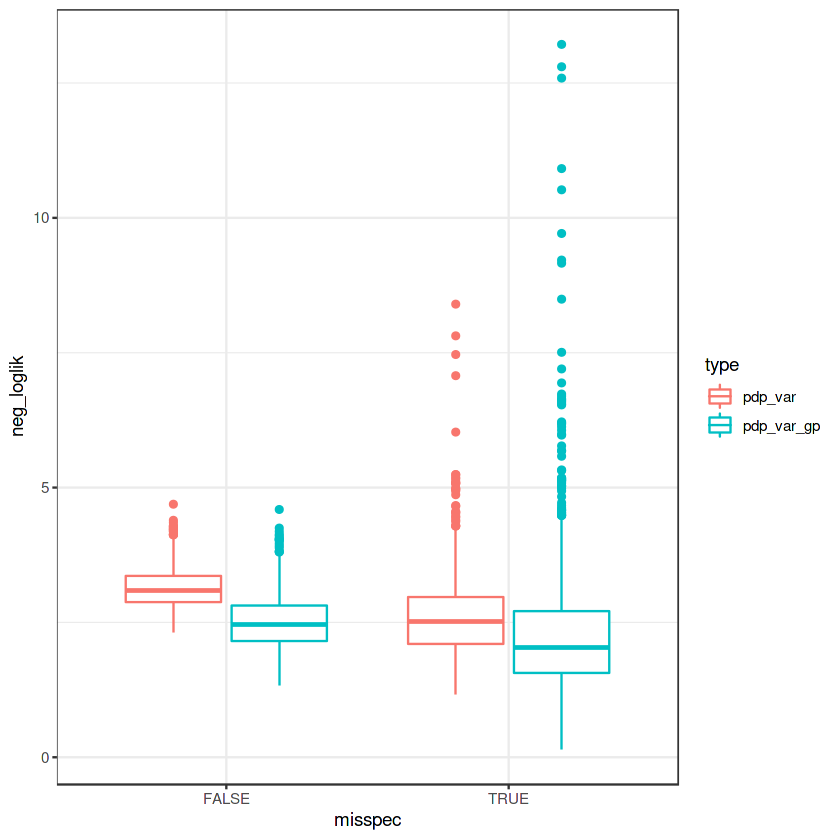

In [57]:
bla_2 = do.call(rbind, out_2)

p = ggplot(data = bla_2, aes(x = misspec, y = neg_loglik, colour = type)) + geom_boxplot() #+ ylim(c(0, 50))
p

In [58]:
# Create a Table 
bla_2_s = setDT(bla_2)[, .(mean(neg_loglik), sd(neg_loglik)), by = c("misspec", "type", "dimension")]

In [59]:
bla_2_s$variant = paste0(bla_2_s$type, "_", bla_2_s$misspec)
bla_2_s$value = paste0(round(bla_2_s$V1, 2), " (", round(bla_2_s$V2, 2), ")")

In [60]:
reshape2::dcast(bla_2_s, formula = dimension ~ variant, value.var = "value")

dimension,pdp_var_FALSE,pdp_var_gp_FALSE,pdp_var_gp_TRUE,pdp_var_TRUE
<dbl>,<chr>,<chr>,<chr>,<chr>
2,3.15 (0.38),2.51 (0.49),2.34 (1.36),2.64 (0.76)


In [65]:
out_5 = lapply(seq_len(50), function(i) {
        res = simulate_kernel(dimension = 5, true_kernel = "matern3_2", wrong_kernel = "matern5_2", n = 30)
        res$iter = i
    
        res
})


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  18.7852 19.22764 18.60986 18.74395 18.76872 
  - best initial criterion value(s) :  -164.3145 

N = 5, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       164.31  |proj g|=       0.4809
At iterate     1  f =       164.19  |proj g|=       0.63186
At iterate     2  f =       164.09  |proj g|=       0.66249
At iterate     3  f =       163.95  |proj g|=       0.22444
At iterate     4  f =       163.78  |proj g|=       0.16338
At iterate     5  f =       163.61  |proj g|=       0.23253
At iterate     6  f =       163.54  |proj g|=        0.6765
At iterate     7  f =       163.46  |proj g|=       0.45843
At iterate     8  f =       163.31  

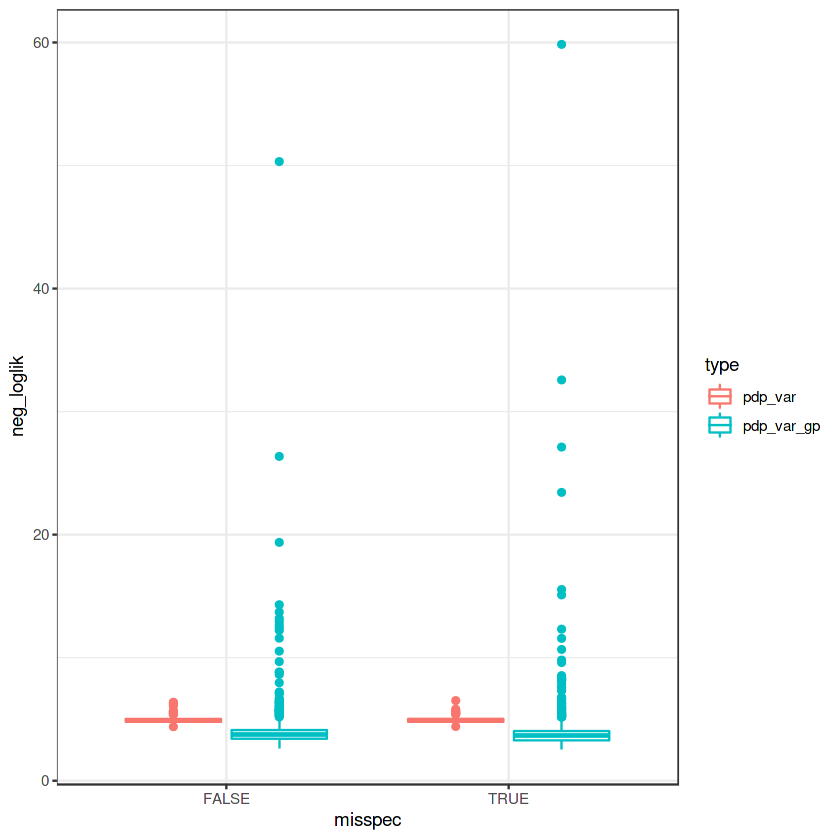

In [66]:
bla_5 = do.call(rbind, out_5)

p = ggplot(data = bla_5, aes(x = misspec, y = neg_loglik, colour = type)) + geom_boxplot() #+ ylim(c(0, 50))
p

In [ ]:
# Create a Table 
bla_5_s = setDT(bla_5)[, .(mean(neg_loglik), sd(neg_loglik)), by = c("misspec", "type", "dimension")]

bla_5_s$variant = paste0(bla_5_s$type, "_", bla_5_s$misspec)
bla_5_s$value = paste0(round(bla_5_s$V1, 2), " (", round(bla_5_s$V2, 2), ")")

reshape2::dcast(bla_5_s, formula = dimension ~ variant, value.var = "value")

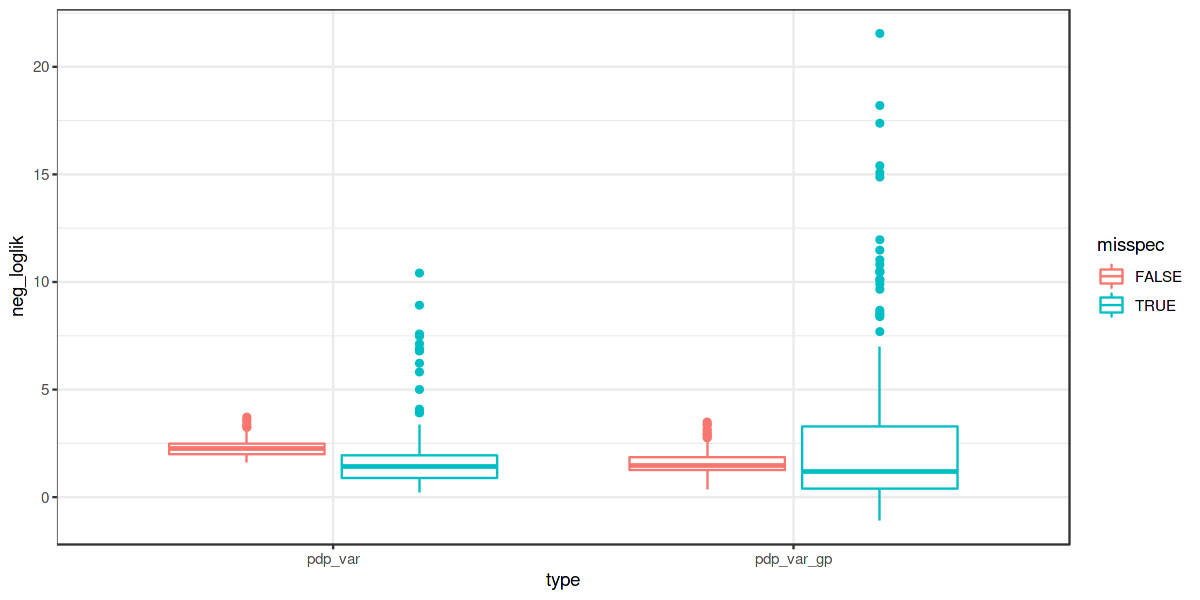

In [583]:
bla = do.call(rbind, out)

p = ggplot(data = bla, aes(x = type, y = neg_loglik, colour = misspec)) + geom_boxplot() #+ ylim(c(0, 50))
p

In [584]:
out = replicate(n = 10, simulate_kernel(dimension = 10, true_kernel = "matern3_2", wrong_kernel = "matern5_2", n = 50, objective = obj), simplify = FALSE)


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.50605 19.70826 
  - best initial criterion value(s) :  -199.1767 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       199.18  |proj g|=      0.59707
At iterate     1  f =       198.62  |proj g|=       0.52747
At iterate     2  f =       193.41  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value 193.415

F = 193.415
final  value 193.414848 
converged

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical 

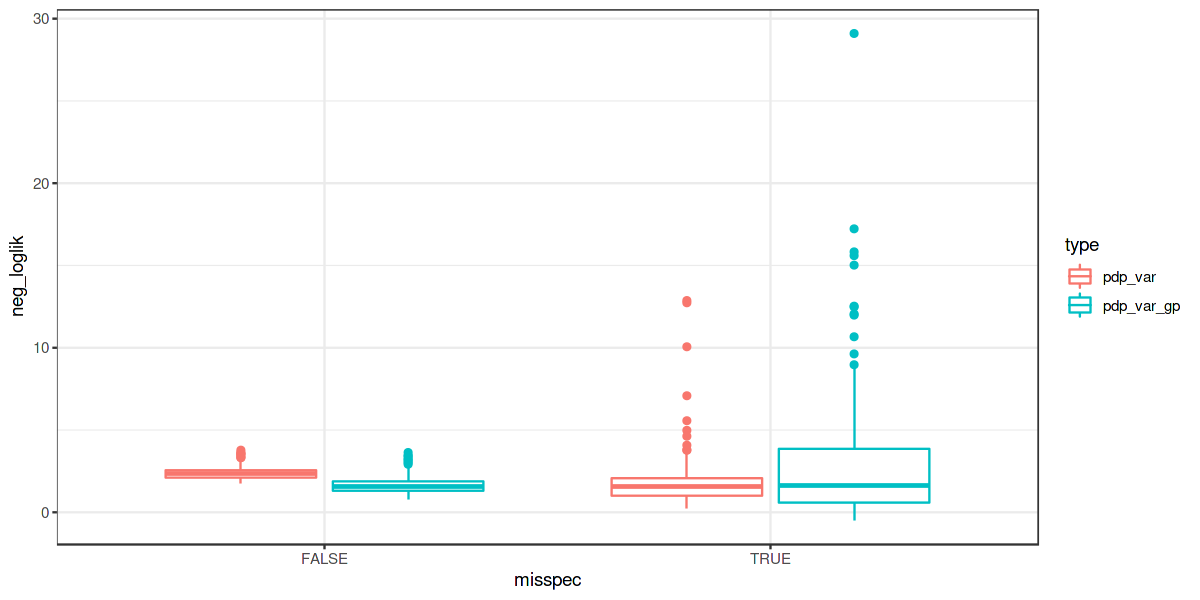

In [586]:
bla = do.call(rbind, out)

p = ggplot(data = bla, aes(x = misspec, y = neg_loglik, colour = type)) + geom_boxplot() #+ ylim(c(0, 50))
p

In [605]:
bla = setDT(bla)

In [608]:
out = bla[, .(mean_negloglik = mean(neg_loglik), sd_negloglik = sd(neg_loglik)), by = c("misspec", "type")]

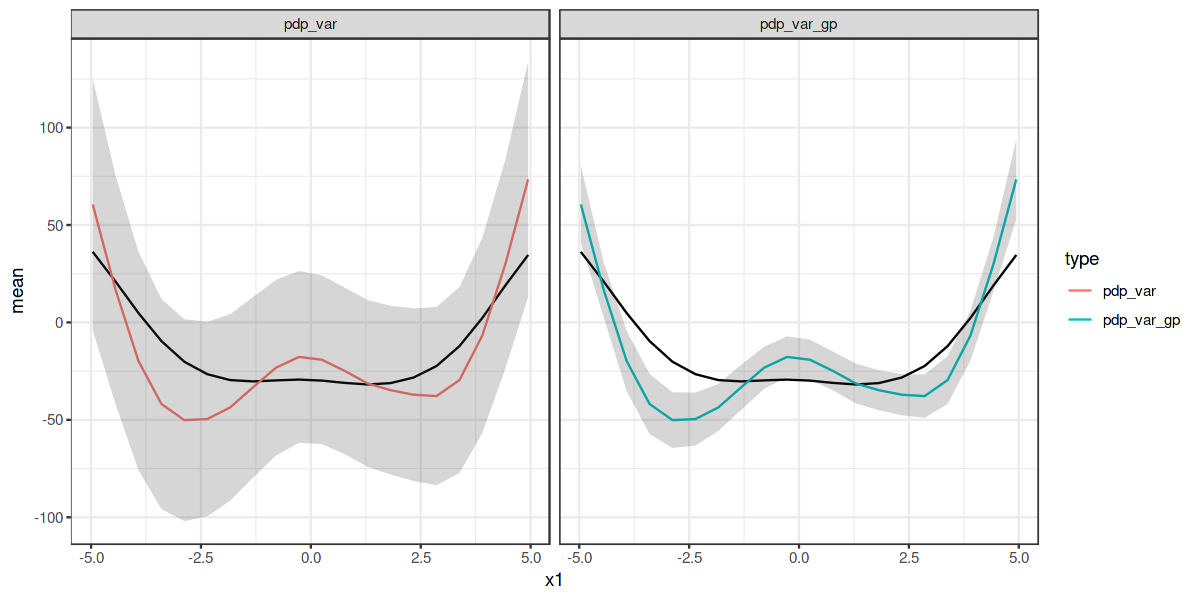

In [541]:
options(repr.plot.width=10, repr.plot.height=5)

p1 = p + geom_line(data = me_pdp1, aes(x = x1, y = mean, colour = type))
p1 = p1 + geom_ribbon(data = me_pdp1, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
p1 = p1 + facet_wrap(. ~ type)
p1


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  19.39747 19.92761 19.83641 19.40239 19.15312 
  - best initial criterion value(s) :  -278.5375 

N = 5, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       278.54  |proj g|=           16
At iterate     1  f =       277.88  |proj g|=       0.21775
At iterate     2  f =       277.88  |proj g|=       0.17378
At iterate     3  f =       277.88  |proj g|=       0.17506
At iterate     4  f =       277.88  |proj g|=       0.38435
At iterate     5  f =       277.88  |proj g|=       0.83894
At iterate     6  f =       277.87  |proj g|=        1.5397
At iterate     7  f =       277.85  |proj g|=        2.5905
At iterate     8  f =       277.81 

x1,mean,sd,type,neg_loglik,mean.gt
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
-4.9875543,-3.110099,15.47938,pdp_var_gp,3.807779,-11.56960
-4.4623627,-4.483186,14.90378,pdp_var_gp,3.744703,-11.90968
-3.9371710,-5.694552,14.37867,pdp_var_gp,3.685955,-12.16560
-3.4119794,-6.714708,13.91369,pdp_var_gp,3.632234,-12.29486
-2.8867877,-7.531807,13.51179,pdp_var_gp,3.583964,-12.26913
-2.3615961,-8.154609,13.16946,pdp_var_gp,3.542329,-12.12688
-1.8364044,-8.605626,12.87836,pdp_var_gp,3.507823,-11.93097
-1.3112128,-8.910152,12.62791,pdp_var_gp,3.479854,-11.73420
-0.7860211,-9.088375,12.40815,pdp_var_gp,3.457257,-11.56785
